# Pipe1 : 
## To check if user input image is a car or not. Tested against multiple cnn frameworks to find one with maximum accuracy.

### Data0 - dataset of all images of cars(damaged and undamaged ones)

In [3]:
import os
import h5py
import urllib.request
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk
from IPython.display import Image, display, clear_output
from collections import Counter, defaultdict
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
import tensorflow as tf

In [6]:
from keras import optimizers
from keras.applications.vgg16 import VGG16
#from keras.applications.vgg19 import VGG19
#from keras.applications.resnet50 import ResNet50
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.xception import Xception
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, History

In [7]:
CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

In [8]:
vgg16 = VGG16(weights='imagenet')
#vgg19 = VGG19(weights='imagenet')
#resnet = ResNet50(weights='imagenet')
#inception = InceptionV3(weights='imagenet')
#xception = Xception(weights='imagenet')

553476096/553467096 [==============================] - 235s 0us/step


In [9]:
def prepare_image_224(img_path):
    img = load_img(img_path, target_size=(224,224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [10]:
def prepare_image_299(img_path):
    img = load_img(img_path, target_size=(299,299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [11]:
def get_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',CLASS_INDEX_PATH,cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

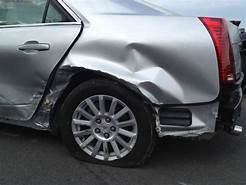

In [14]:
Image('testimage.jpeg')

### Testing with different models 

In [16]:
y = prepare_image_224('testimage.jpeg')
preds = vgg16.predict(y)
print(get_predictions(preds, top=5))

49152/35363 [=========================================] - 0s 5us/step
[[('n03100240', 'convertible', 0.283259), ('n03930630', 'pickup', 0.1792785), ('n03670208', 'limousine', 0.16034336), ('n04285008', 'sports_car', 0.10271571), ('n03770679', 'minivan', 0.072801545)]]


In [12]:
z = prepare_image_224('testimage.jpg')
preds = vgg19.predict(z)
print(get_predictions(preds, top=5))

[[('n03100240', 'convertible', 0.26360297), ('n03930630', 'pickup', 0.14805934), ('n03770679', 'minivan', 0.14723605), ('n04285008', 'sports_car', 0.12050969), ('n02814533', 'beach_wagon', 0.11459463)]]


In [13]:
a = prepare_image_224('testimage.jpg')
preds = resnet.predict(a)
print(get_predictions(preds))

[[('n03770679', 'minivan', 0.23549458), ('n02814533', 'beach_wagon', 0.13592634), ('n04285008', 'sports_car', 0.11415414), ('n03930630', 'pickup', 0.10745103), ('n02974003', 'car_wheel', 0.081083775)]]


In [14]:
b = prepare_image_299('testimage.jpg')
preds = inception.predict(b)
print(get_predictions(preds, top=5))

[[('n01924916', 'flatworm', 1.0), ('n03047690', 'clog', 8.942e-12), ('n03065424', 'coil', 1.4942996e-14), ('n04325704', 'stole', 1.5525325e-16), ('n02089973', 'English_foxhound', 6.774755e-17)]]


In [15]:
c = prepare_image_299('testimage.jpg')
preds = xception.predict(c)
print(get_predictions(preds, top=5))

[[('n03763968', 'military_uniform', 0.36981878), ('n03942813', 'ping-pong_ball', 0.36295855), ('n03825788', 'nipple', 0.09450442), ('n02099712', 'Labrador_retriever', 0.046820126), ('n02769748', 'backpack', 0.046718605)]]


##### Result: VGG16 shows best accuracy.

## Using VGG16 model for Pipe1

In [17]:
def get_car_categories():
    d = defaultdict(float)
    img_list = os.listdir('data1')
    for i, img_path in enumerate(img_list):
        img = prepare_image_224('data1/'+img_path)
        out = vgg16.predict(img)
        preds = get_predictions(out,top=5)
        for pred in preds[0]:
            d[pred[0:2]]+=pred[2]
        if(i%50==0):
            print(i,'/',len(img_list),'complete')
    return Counter(d)

In [18]:
categ_count = get_car_categories()

0 / 62 complete
50 / 62 complete


In [19]:
with open('vgg16_cat_list.pk', 'wb') as f:
    pk.dump(categ_count, f, -1)

In [20]:
with open('vgg16_cat_list.pk', 'rb') as f:
    categ_count = pk.load(f)

In [21]:
categ_list = [k for k, v in categ_count.most_common()[:50]]

## Imagenet Car Categories

In [22]:
def get_car_categories(categ_list):
    img_list = os.listdir('data1')
    n = 0
    bad_list = []
    for i, img_path in enumerate(img_list):
        img = prepare_image_224('data1/'+img_path)
        out = vgg16.predict(img)
        preds = get_predictions(out, top=5)
        for pred in preds[0]:
            if pred[0:2] in categ_list:
                n+=1
                break
            else:
                pass
            bad_list.append(img_path)
        if i%100 == 0:
            print(i,'/',len(img_list), 'complete')
    bad_list = [k for k, v in Counter(bad_list).items() if v == 5]
    return n, bad_list

In [23]:
num, bad_list = get_car_categories(categ_list)

0 / 62 complete


# Pipe 1

In [24]:
def pipe1(img_path, categ_list):
    urllib.request.urlretrieve(img_path, 'image.jpg')
    img = prepare_image_224('image.jpg')
    out = vgg16.predict(img)
    preds = get_predictions(out, top=5)
    print("Ensuring entered picture is a car...")
    for pred in preds[0]:
        if pred[0:2] in categ_list:
            print(pred[0:2])
            return "Successful. Proceeding to damage assessment..."
    return "The entered image is a not a car. Please try again. Consider a different angle or lighting."

In [25]:
pipe1('https://www.autoauctionmall.com/learning-center/contents/uploads/2015/10/damaged-car.jpg', categ_list)

HTTPError: HTTP Error 403: Forbidden

In [29]:
pipe1('https://cdn.nba.net/nba-drupal-prod/2017-05/lonzo-ball-sideline-iso.jpg',categ_list)

CertificateError: hostname 'cdn.nba.net' doesn't match either of 'www.turner.com', '*.adultswim.com', '*.cdn.adultswim.com', 'alwayshereforyou.com', '*.ben10.com', '*.bleacherreport.com', '*.cartoonnetwork.asia', '*.cartoonnetwork.com', '*.staging.cartoonnetwork.com', '*.cartoonnetworkasia.com', '*.cartoonnetworkkorea.com', '*.cartoonnetworkpr.com', 'celebrityshowoff.com', '*.celebrityshowoff.com', '*.chasingthecurelive.com', '*.cnn.com', '*.cerebro.api.cnn.com', '*.cdn.cnn.com', '*.go.cnn.com', '*.money.cnn.com', '*.cnn.io', '*.eleague.com', '*.filmstruck.com', '*.latamwbd.com', 'data.nba.net', '*.ncaa.com', '*.mml.ncaa.com', '*.mml-desktop.ncaa.com', '*.mml-web.ncaa.com', '*.turner.ncaa.com', '*.ngtv.io', '*.powerpufftheworld.com', '*.sambee.com', '*.stevenuniverseselfesteem.com', '*.superstation.com', '*.tbs.com', '*.cdn.tbs.com', '*.nycf.tbs.com', '*.tcm.com', '*.cdn.tcm.com', '*.ti-platform.com', '*.i.cdn.ti-platform.com', '*.tnt.tv', '*.tntdrama.com', '*.cdn.tntdrama.com', 'tournamentoflaughs.com', '*.tournamentoflaughs.com', '*.trutv.com', '*.cdn.trutv.com', '*.turner.com', '*.cdn.turner.com', '*.dynaimage.cdn.turner.com', 'warnerbrosdiscoveryready.com', '*.warnerbrosdiscoveryready.com', '*.warnermediacdn.com', '*.wbd.com', 'wbdready.com', '*.wbdready.com', 'turner.com'

In [28]:
pipe1('https://tse4.mm.bing.net/th?id=OIP.FaZela57De0uzfVxVY3JJQHaEo&pid=Api&P=0&w=289&h=181', categ_list)

Ensuring entered picture is a car...
('n04037443', 'racer')


'Successful. Proceeding to damage assessment...'